In [2]:
using Plots
using LinearAlgebra
using HCubature
using StaticArrays

┌ Warning: Error requiring IJulia from Plots:
│ MethodError: no method matching joinpath(::Nothing)
│ Closest candidates are:
│   joinpath(!Matched::AbstractString) at path.jl:244
│   joinpath(!Matched::AbstractString, !Matched::AbstractString...) at path.jl:289
│ Stacktrace:
│  [1] stat(::Nothing) at ./stat.jl:109
│  [2] isfile(::Nothing) at ./stat.jl:311
│  [3] _init_ijulia_plotting() at /home/skoghm/.julia/packages/Plots/jIs2V/src/ijulia.jl:7
│  [4] top-level scope at /home/skoghm/.julia/packages/Plots/jIs2V/src/init.jl:75
│  [5] eval at ./boot.jl:331 [inlined]
│  [6] eval at /home/skoghm/.julia/packages/Plots/jIs2V/src/Plots.jl:1 [inlined]
│  [7] (::Plots.var"#277#310")() at /home/skoghm/.julia/packages/Requires/vyVBT/src/require.jl:97
│  [8] err(::Any, ::Module, ::String) at /home/skoghm/.julia/packages/Requires/vyVBT/src/require.jl:42
│  [9] (::Plots.var"#276#309")() at /home/skoghm/.julia/packages/Requires/vyVBT/src/require.jl:96
│  [10] withpath(::Any, ::String) at /home/skoghm

# Hartree-Fock Program

The task is to write a Hartree-Fock program that can solve problems involving hydrogen atoms. The STO-3G basis set should be used. 

## Defining our basis
In general we have that for a STO-$n$G basis set centered on an atom at $R$ and for a given principal quantum number $s$ at a point $r$ is

$$\Psi_{\mathrm{STO-}n\mathrm{G}}(s, R, r) = \sum_{i=1}^n c_i \phi_i(R,r)$$

and

$$\phi_i(R, r) = \left(\frac{2\alpha_i}{\pi}\right)^{3/4} e^{-\alpha |R-r|^2}$$

where the $s$-dependence comes in through the coefficients and exponents.

In the task we know that $n=3$ and we are given then exponents $\alpha_i$ as the values give in the textbook. Since I do not have the textbook here, I will use the values given by [basis set exchange](https://www.basissetexchange.org/) (the JSON format can be used for downloading to clearly see which values are exponents and which are coefficents).

From the basis set exchange we see that the exponents are:

|            |                  |
|------------|------------------|
|$\alpha_1$  |  3.425250914     |
|$\alpha_2$  |  0.6239137298    |
|$\alpha_3$  |  0.1688554040    |

In [3]:
exponents = [3.425250914, 0.6239137298, 0.1688554040]

3-element Array{Float64,1}:
 3.425250914
 0.6239137298
 0.168855404

Now we can start coding. Let's start by making a gaussian function. To simplify the code a bit, we will implement two versions: one where we use the same look as above, and another where we just care about the distance $d = |R - r|$ (this is just tio make it easier to vectorize later).

In [4]:
gaussian_primitive(α::Number, d::Number) = (2 * α / π ) ^ (3/4) * exp(-α * d ^ 2)
gaussian_primitive(α, r::SArray{Tuple{3},Float64,1,3}) = gaussian_primitive(α, norm(r)^2)
gaussian_primitive(α, r::AbstractVector{<:Number}) = gaussian_primitive(α, norm(r)^2)

gaussian_primitive(α, R, r) = gaussian_primitive(α, norm(R - r)^2) # reusing our function above, and assuming cartesian coordinates

gaussian_primitive (generic function with 4 methods)

In [5]:
norm([1,1,1])

1.7320508075688772

In [7]:
function STOnG(coefficients, exponents, d)
    return sum([c * gaussian_primitive.(α, d) for (c, α) in zip(coefficients, exponents)])
end

STOnG (generic function with 1 method)

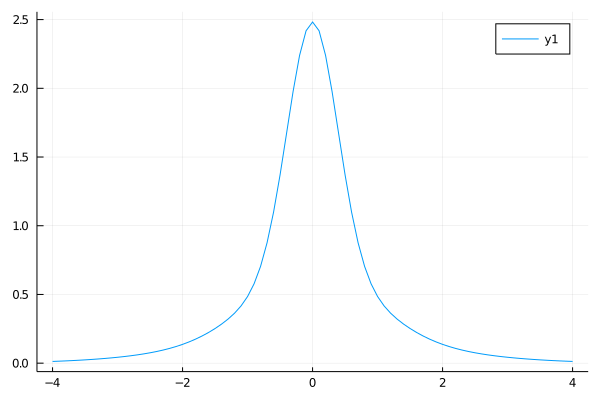

In [8]:
coefficients = [1, 1, 1]
d = -4:0.1:4

y = STOnG(coefficients, exponents, d)

plot(d, y)

## Integrating our Gaussians

We should also integrate this so that we can normalize it later. We want to integrate over all real space, and we have a function of the form 

$$
ae^{-b|r|^2} \Rightarrow a\int_{0}^{2\pi}\int_{0}^{\pi} \int_{0}^\infty r^2 \sin\theta \, e^{-b|r|^2} \mathrm{d}r\, \mathrm{d}\theta \, \mathrm{d}\phi \\
= a\int_{0}^{2\pi} \mathrm{d}\phi \int_{0}^{\pi} \sin\theta \, \mathrm{d}\theta \,   \int_{0}^\infty r^2 e^{-b|r|^2} \mathrm{d}r\, \\
= 2\pi a \int_{0}^\infty r^2 e^{-b|r|^2} \mathrm{d}r = 2\pi a \frac{1}{4}\sqrt{\frac{\pi}{b^3}} =  \frac{a}{2}\left ( \frac{\pi}{b}\right)^{3/2}
$$


We will also work a lot with products of Gaussians which we can simplify as

$$
a_A e^{-b_A |R_A - r|^2} a_B e^{-b_2 |R_B - r|^2} = a_A a_B e^{-(b_A |R_A - r|^2 + b_B |R_B - r|^2) }
$$

by expanding the the exponent $-(b_A |R_A - r|^2 + b_B |R_B - r|^2)$ we can rewrite it as 

$$
-(b_A |R_A - r|^2 + b_B |R_B - r|^2) = -(b_A [r^2 - 2 b_A r + R_A^2] + b_B [r^2 - 2 R_B r + R_B^2] )\\
= -(b_A + b_B)r^2 + 2 (b_A R_A + b_B R_B) r - (b_A R_A^2 + b_B R_B^2)\\ 
= -\alpha r^2 + \beta r + \gamma
$$

Where 

$$
\alpha = (b_A + b_B) \\
\beta = 2(b_A R_A + b_B R_B) \\
\gamma = -(b_A R_A^2 + b_B R_B^2)
$$

The general Gaussian integral looks like

$$
\int_{0}^{\infty} r^2 e^{-ar^2 + br + c} \mathrm{d}r = \frac{1}{2}\sqrt{\frac{\pi}{a^3}} e^{\frac{b^2}{4a} + c}
$$

and the spherical volume integral would then give

$$
\int_{0}^{2\pi} \int_{0}^{\pi} \sin\theta \int_{0}^{\infty} r^2 e^{-ar^2 + br + c} \mathrm{d}r\, \mathrm{d}\theta\, \mathrm{d}\phi = \frac{1}{2}\left( \frac{\pi^3}{a^3} \right)^{3/2} e^{\frac{b^2}{4a} + c}
$$

In [9]:
struct Gaussian
    a::Number
    b::Number
    c::Number
    d::Number
    n::Number
end


Base.:*(x::Gaussian, y::Gaussian) = Gaussian(x.a * y.a, x.b + y.b, x.c + y.c, x.d + y.d, x.n + y.n)


evaluate(G::Gaussian, r) = G.a * r^G.n * exp(-G.b * r^2 + G.c * r + G.d)

derivate(G::Gaussian) = [Gaussian(), Gaussian(), Gaussian()]

laplacian(G::Gaussian) = GaussianLaplacian(G)

integrate_3D(G::Gaussian) = a * (π / b) ^ (3/2) * exp((c^2) / (4 * b) + d)


gaussian_laplacian(α, d) = 2α * (2α^2 - 1) * gaussian_primitive(α, d)


gaussian_laplacian (generic function with 1 method)

In [10]:
gaussian_integral(a, b, c, d) = d * (π / a) ^ (3/2) * exp((b^2) / (4 * a) + c)

gaussian_integral (generic function with 1 method)

Now, if we only could evaluate the energy of this single orbital, we would be able to calculate the energy for a single hydrogen atom.

We can call this the core Hamiltonian, $\hat{H}_{\mathrm{core}}$, i.e. the energy of a single electron due to the interaction with the core as well as kinetic energy.

$$\hat{H}^{\mathrm{core}} = -\frac{\nabla^2}{2} - \sum_{\mathrm{\gamma}} \frac{Z_\gamma}{|r_{\gamma} - r|}$$

where we sum over all nuclei $\gamma$.

The energy is then given by 

$$
\langle \psi | H | \psi \rangle = \iiint dx dy dz\,  \psi^\dagger H \psi = -\iiint dx dy dz\,  \psi^\dagger \left ( \frac{\nabla^2}{2} + \sum_{\mathrm{\gamma}} \frac{Z_\gamma}{|r_{\gamma} - r|} \right ) \psi
$$

The trickiest part of this expression is the second derivatives arising from the $\nabla^2$. However, due to rotational symmetry we can see that when this acts on our gaussian functions we get

$$\nabla^2\phi_i = \frac{\partial^2 \phi_i}{\partial d^2} = 2 \alpha_i (2 \alpha_i d^2 - 1) \left(\frac{2\alpha_i}{\pi}\right)^{3/4} e^{-\alpha_i d^2}$$

In [11]:

function STOnG_laplacian(coefficients, exponents, d)
    return sum([c * gaussian_laplacian.(α, d) for (c, α) in zip(coefficients, exponents)])
end

STOnG_laplacian (generic function with 1 method)

In [12]:
coefficients = [1, 1, 1]
exponents = [3.425250914, 0.6239137298, 0.1688554040]

nuclei_pos = [0,0,0]
charge = 1
nbr_electrons = 1

d = -4:0.01:4

kinetic_density(r) = -1/2 .* STOnG(coefficients, exponents, norm(r)) .* STOnG_laplacian(coefficients, exponents, norm(r))
coloumb_density(r) = - charge./norm(r) .* STOnG(coefficients, exponents, norm(r)) .* STOnG(coefficients, exponents, norm(r))

coloumb_density (generic function with 1 method)

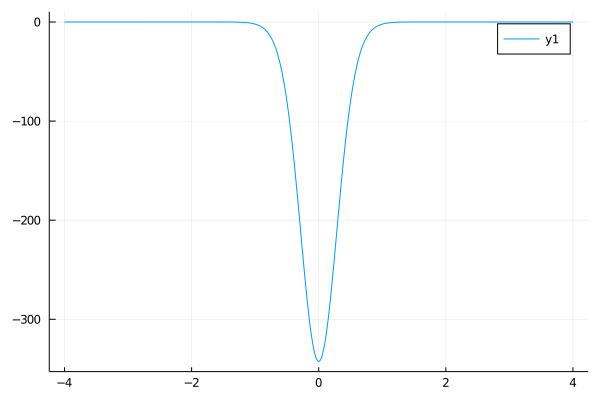

In [13]:
plot(d, kinetic_density.(d))

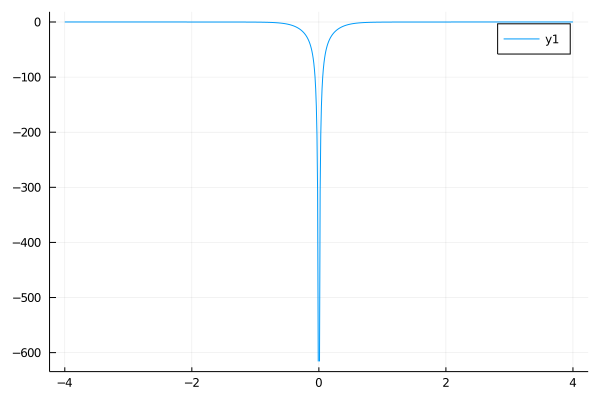

In [14]:
plot(d, coloumb_density.(d))

In [15]:
kinetic_energy = monte_carlo_integral(kinetic_density, [-5; -5; -5], [5; 5; 5], 1e7, 0, 1)

LoadError: UndefVarError: monte_carlo_integral not defined

In [16]:
coloumb_energy = monte_carlo_integral(coloumb_density, [-5; -5; -5], [5; 5; 5], 1e7, 0, 1)

LoadError: UndefVarError: monte_carlo_integral not defined

In [17]:
plot(d, coloumb_energy)

LoadError: UndefVarError: coloumb_energy not defined

## Making it faster

It can be convinient to work in spherical coordinates now, that is:

$$
x = \rho\sin\theta\cos\varphi\\
y = \rho\sin\theta\sin\varphi\\
z = \rho\cos\theta\\
$$

where I have used $\rho$ instead of $r$ when compairing to the figure below.

![image.png](https://upload.wikimedia.org/wikipedia/commons/4/4f/3D_Spherical.svg)

Looks good! So now we can start making the actual STO-$n$G function.

Which we again test to make sure that it produces what we expect.

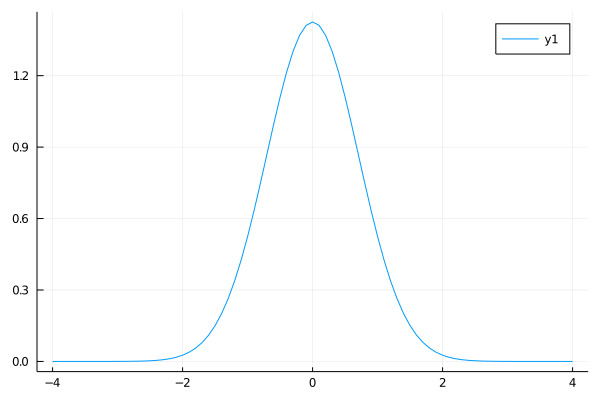

In [18]:
α = 1
d = -4:0.1:4 # okay, we can't have neagtive distances, but it makes for a prettier plot...

y = gaussian_laplacian.(α, d) # Use the dot before the arguments to vectorize

plot(d, y)

In [19]:
plot(d, total_energy)

LoadError: UndefVarError: total_energy not defined